# Convolutional Kernels - SVM Kernels

When the data distribution is not linear we cant apply a normal linear regression. 
For a non-linear data a new SVM Kernel is needed to apply regression.

The general solution is given by:
$$\max\left(\sum_{i =1} b_i - \frac{1}{2}\sum_{i=1}^n\sum_{j = 1}^n y_ib_ik(x_i, x_j)y_jb_j\right)$$

-With the following restrictions
- $\sum_{i=1}^n b_i y_i = 0$
- $ 0 \le b_i \le \frac{1}{2n\gamma}$

SVM **kernel** $k$ would be:
- General case --> $k(x_i, x_j) = \phi(x_i)\cdot(x_j)$
- Linear case --> $k(x_i,x_j) = x_i\cdot x_j $
- Gaussian Kernel --> $k(x_i, x_j) = e^{-\gamma||x_i-x_j||²}$
    - Prediction --> $k(x_i,p_j) = e^{-\gamma||x_i-p_j||²}$ (where $p_j$ is the point to be predicted)
- Homogeneous polynomial kernel --> $k(x_i, x_j) = (x_i \cdot x_j)^d$
- Non homogeneous polynomial kernel --> $k(x_i, x_j) = (x_i \cdot x_j + 1)^d$
- Hyperbolic tangent kernel --> $k(x_i, x_j) = tanh(a x_i \cdot x_j  +k)$

## Library and dataset import

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import datasets
%config Completer.use_jedi = False
session = tf.Session()

## Dataset creation

Lets create 2 different distributions. The idea is that one of each have a circular distribution with the objetive of use a Gaussian kernel for the regression problem

In [3]:
(x_vals, y_vals) = datasets.make_circles(n_samples=500, factor=0.5, noise=0.1,)
y_vals = np.array([1 if y==1 else -1 for y in y_vals])    #Interpolate values to 1 and -1 to use SVM

class1_x = [x[0] for i, x in enumerate(x_vals) if y_vals[i] == 1]
class1_y = [x[1] for i, x in enumerate(x_vals) if y_vals[i] == 1]

class2_x = [x[0] for i, x in enumerate(x_vals) if y_vals[i] == -1]
class2_y = [x[1] for i, x in enumerate(x_vals) if y_vals[i] == -1]

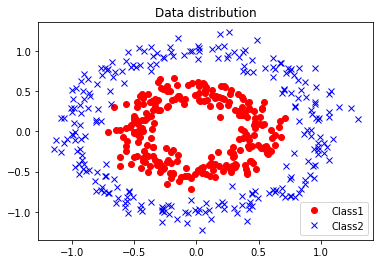

In [8]:
plt.plot(class1_x, class1_y, 'ro', label = 'Class1')
plt.plot(class2_x, class2_y, 'bx', label = 'Class2')
plt.legend(loc = 'lower right')
plt.title('Data distribution')
plt.show()

### Variable creation

In [12]:
batch_size = 500   #Same number as the datapoints, each point needs a iteration 
x_data = tf.placeholder(shape = [None, 2], dtype = tf.float32)
y_target = tf.placeholder(shape = [None, 1], dtype = tf.float32)
prediction_grid = tf.placeholder(shape = [None, 2], dtype = tf.float32)
b = tf.Variable(tf.random_normal(shape = [1, batch_size]))   #Initialize variable with normal distribution with 1 column and batch size rows

### Gaussian kernel

In [15]:
gamma = tf.constant(-50.0)
dist = tf.reduce_sum(tf.square(x_data), 1)
dist = tf.reshape(dist, [-1, 1])
sq_dist = tf.add(tf.subtract(dist, tf.multiply(2.0, tf.matmul(x_data, tf.transpose(x_data)))), tf.transpose(dist))
my_kernel = tf.exp(tf.multiply(gamma, tf.abs(sq_dist)))

### SVM general solution

In [34]:
first_sum = tf.reduce_sum(b)
b_vect_cross = tf.matmul(tf.transpose(b), b)
y_target_cross = tf.matmul(y_target, tf.transpose(y_target))

second_sum = tf.reduce_sum(tf.multiply(my_kernel, tf.multiply(b_vect_cross, y_target_cross)))
loss = tf.negative(tf.subtract(first_sum, second_sum))

### Prediction Kernel

In [20]:
rA = tf.reshape(tf.reduce_sum(tf.square(x_data), 1), [-1, 1])
rB = tf.reshape(tf.reduce_sum(tf.square(prediction_grid), 1), [-1, 1])

pred_sq_dist = tf.add(tf.subtract(rA, tf.multiply(2.0, tf.matmul(x_data, tf.transpose(prediction_grid)))), tf.transpose(rB))
pred_kernel = tf.exp(tf.multiply(gamma, tf.abs(pred_sq_dist)))
prediction_output = tf.matmul(tf.multiply(tf.transpose(y_target), b), pred_kernel)
prediction = tf.sign(prediction_output - tf.reduce_mean(prediction_output))

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.squeeze(prediction), tf.squeeze(y_target)), tf.float32))

### Train algorithm

In [35]:
learning_rate = 0.002
my_opt = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
train_step = my_opt.minimize(loss)

### Variable initilization

In [36]:
init = tf.global_variables_initializer()
session.run(init)

## Model training

In [37]:
loss_vect = []
batch_acc = []

for i in range(1000):
    rand_idx = np.random.choice(len(x_vals), size = batch_size)
    rand_x = x_vals[rand_idx]
    rand_y = np.transpose([y_vals[rand_idx]])
    session.run(train_step, feed_dict= {x_data: rand_x,
                                        y_target: rand_y})
    temp_loss = session.run(loss, feed_dict= {x_data: rand_x,
                                              y_target: rand_y})
    loss_vect.append(temp_loss)
    
    temp_acc = session.run(accuracy, feed_dict= {x_data: rand_x,
                                                 y_target: rand_y,
                                                 prediction_grid: rand_x})
    batch_acc.append(temp_acc)
    
    if (i+1)%50 == 0:
        print('Step #'+str(i+1)+
              'Loss = '+str(temp_loss)+
              'Accuracy = '+str(temp_acc))

Step #50Loss = 314.43204Accuracy = 0.64
Step #100Loss = 209.48087Accuracy = 0.59
Step #150Loss = 167.82867Accuracy = 0.626
Step #200Loss = 91.53026Accuracy = 0.628
Step #250Loss = 78.86681Accuracy = 0.728
Step #300Loss = 34.028637Accuracy = 0.71
Step #350Loss = 17.240543Accuracy = 0.816
Step #400Loss = 11.897169Accuracy = 0.862
Step #450Loss = -1.7336216Accuracy = 0.92
Step #500Loss = -1.7343273Accuracy = 0.92
Step #550Loss = -6.53179Accuracy = 0.948
Step #600Loss = -7.4075336Accuracy = 0.956
Step #650Loss = -9.84449Accuracy = 0.996
Step #700Loss = -9.582709Accuracy = 0.978
Step #750Loss = -10.306054Accuracy = 0.982
Step #800Loss = -11.99774Accuracy = 0.996
Step #850Loss = -12.241386Accuracy = 0.998
Step #900Loss = -11.858976Accuracy = 0.992
Step #950Loss = -11.652254Accuracy = 0.99
Step #1000Loss = -12.905184Accuracy = 0.994


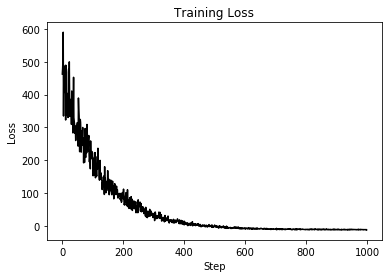

In [38]:
plt.plot(loss_vect, 'k-')
plt.title('Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

### Result visualization

To visualizate correctly the data first we need to create a grid with points that need to be predicted by the
SVM regressor, then we can plot  the regression results with the data points to see how accurate our algorithm is.

In [41]:
x_min, x_max = x_vals[:, 0].min()-1, x_vals[:, 0].max()+1
y_min, y_max = x_vals[:, 0].min()-1, x_vals[:, 0].max()+1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))

grid_points = np.c_[xx.ravel(), yy.ravel()]

[grid_predictions] = session.run(prediction, feed_dict={x_data: x_vals,
                                                       y_target: np.transpose([y_vals]),
                                                       prediction_grid: grid_points})

grid_predictions = grid_predictions.reshape(xx.shape)

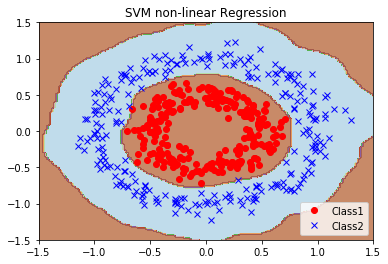

In [44]:
plt.contourf(xx, yy, grid_predictions, cmap = plt.cm.Paired, alpha = 0.7)
plt.plot(class1_x, class1_y, 'ro', label = 'Class1')
plt.plot(class2_x, class2_y, 'bx', label = 'Class2')
plt.legend(loc = 'lower right')
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])
plt.title('SVM non-linear Regression')
plt.show()

### Metrics

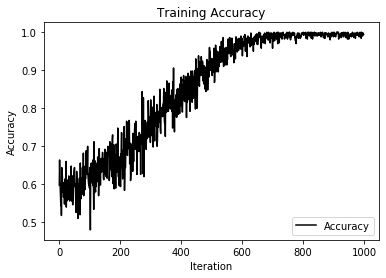

In [45]:
plt.plot(batch_acc, 'k-', label = 'Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')
plt.show()